# V.1 Exploring the green reds

### a) Funciton to display the Scatter Plot Matrix

In [39]:
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


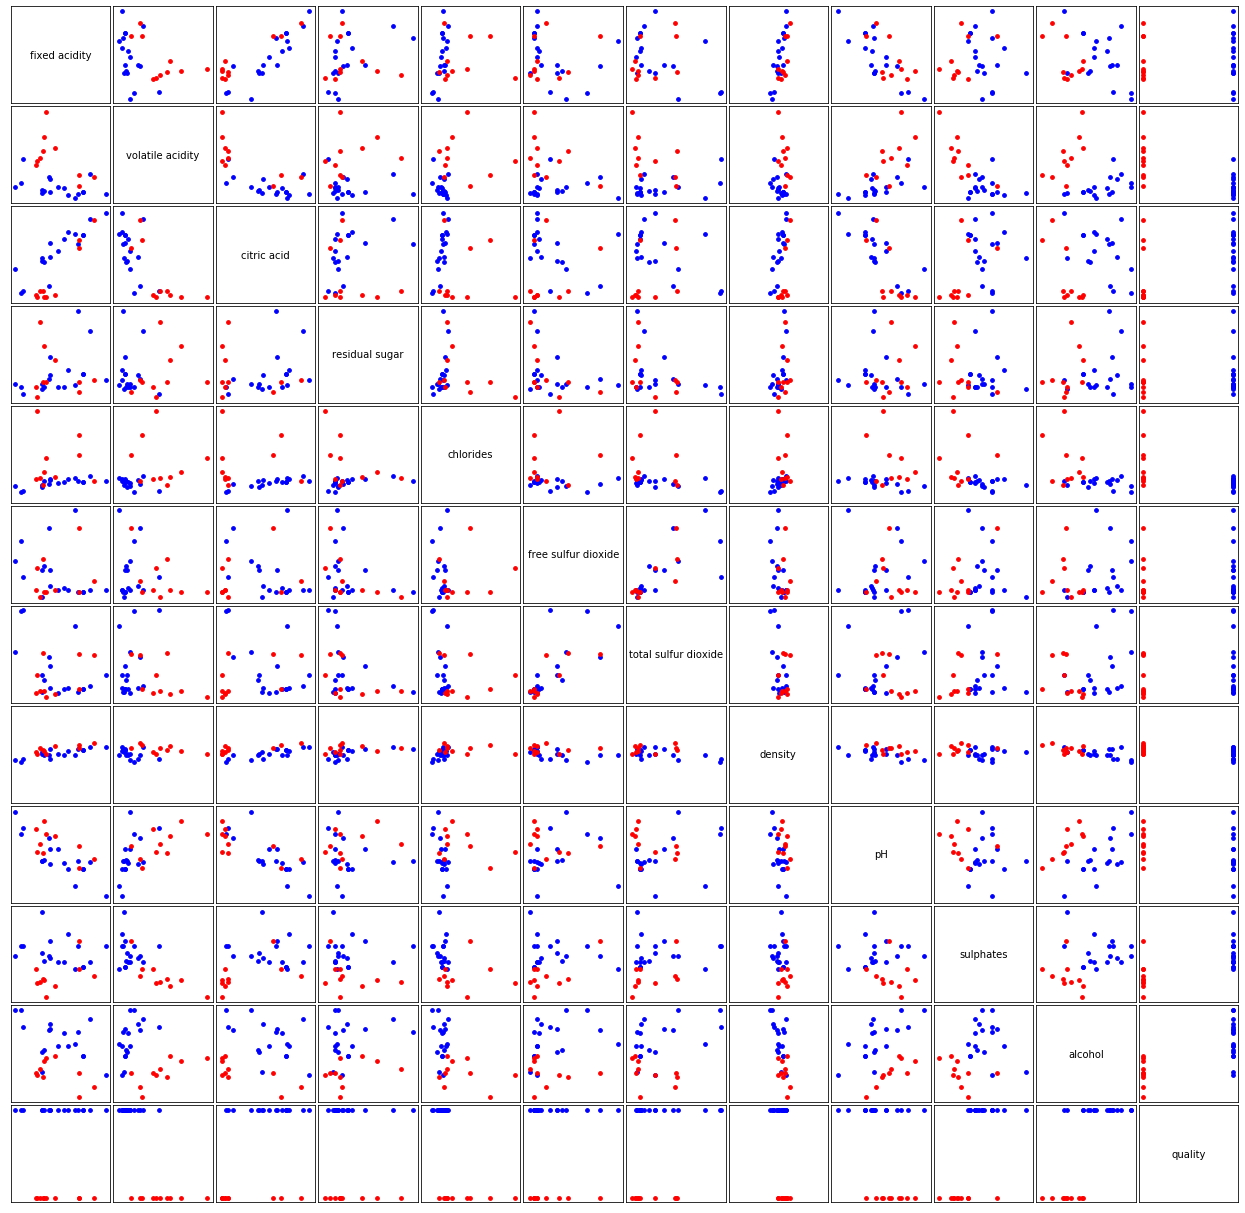

In [31]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    """
    Function to plot the Scatter Matrix.
    If shows relations between each pair of wine parameters.
    ----------
    Parameters
    ----------
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    good_threshold: int, the quality for good wines
    bad_threshold: int, the quality for bad wines
    save_plot: boolean, deafault: False, if True -> save scatter matrix as png
    """
    rows, cols = wine_data.shape
    fig, axes = plt.subplots(nrows=cols, ncols=cols, figsize=(22, 22))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)
    good_wines = wine_data[wine_data['quality'] >= good_threshold]
    bad_wines = wine_data[wine_data['quality'] <= bad_threshold]
    good_wine_color = "blue"
    bad_wine_color = "red"

    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    for i in range(cols):
        for j in range(i + 1, cols):
            axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], c=good_wine_color, s=14)
            axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], c=bad_wine_color, s=14)
            axes[j, i].scatter(good_wines.iloc[:, i], good_wines.iloc[:, j], c=good_wine_color, s=14)
            axes[j, i].scatter(bad_wines.iloc[:, i], bad_wines.iloc[:, j], c=bad_wine_color, s=14)

    for i, label in enumerate(wine_data.columns):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                           ha='center', va='center')

    if save_plot:
        fig.savefig('scatterplot_matrix.png')

    return fig


fig = plot_scatter_matrix(red_wine, 8, 3)

### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines?
I think, the best factors for distinguishing are:
* Alcohol
* Sulphates
* Volatile Acidity

And the worst factors:
* Residual sugar
* Free sulfur dioxide
* pH

# V.2 Learning to perceptron

### a) Implement a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
* Utilizes the heaviside step activation function (discrete version)

### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
* Have a way to specify number of training epochs
* Train your perceptron until it makes no errors, if training epochs is set to 0,
* Have a way to specify learning rate.
* Return a list of python tuples containing (performance):

In [320]:
def train_split(wine_data, features_list, good_threshold=8, bad_threshold=3):
    """
    Splits the wine data into inputs list and answers list.
    ----------
    Parameters
    ----------
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    features_list: list, containing feature column names
    good_threshold, int, default: 8, quality of good wines
    bad_threshold, int, default: 3, quality of bad wines
    ------------
    Return Value
    ------------
    A tuple, containing features data and answers.
    """
    test_data = red_wine[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
    test_data = test_data.reset_index(drop=True)
    X = test_data[x_cols].values
    y = test_data['quality']
    y.loc[y <= bad_threshold] = 0.0
    y.loc[y >= good_threshold] = 1.0
    return tuple([X, y])
X, y = train_split(red_wine, ['alcohol', 'pH'], good_threshold=8, bad_threshold=3)
X

array([[12.8 ,  3.35],
       [12.6 ,  3.23],
       [12.9 ,  3.56],
       [ 9.8 ,  2.88],
       [13.4 ,  3.22],
       [ 9.  ,  3.25],
       [11.7 ,  3.15],
       [11.  ,  3.15],
       [11.  ,  3.15],
       [ 8.4 ,  3.16],
       [14.  ,  3.72],
       [10.7 ,  3.63],
       [12.7 ,  3.46],
       [ 9.9 ,  3.38],
       [11.  ,  3.48],
       [12.5 ,  3.21],
       [11.8 ,  2.98],
       [13.1 ,  3.2 ],
       [11.7 ,  3.35],
       [14.  ,  3.5 ],
       [10.9 ,  3.5 ],
       [ 9.8 ,  3.32],
       [10.  ,  3.23],
       [11.3 ,  3.23],
       [ 9.7 ,  3.31],
       [10.2 ,  3.4 ],
       [ 9.95,  3.55],
       [11.4 ,  3.24]])

In [351]:
class Perceptron:
    def __init__(self, learning_rate):
        self.weights = None
        self.lr = learning_rate
    
    def predict(self, row):
        """Heaviside step activation function."""
        activation = self.weights[0]
        for i in range(len(row)):
            activation += self.weights[i + 1] * row[i]
        return 1.0 if activation >= 0.0 else 0.0
        
    def fit(self, X, y, epochs_num):
        """
        Function to train perceptron.
        It changes weights after each epoch to make more accurate predictions.
        ----------
        Parameters
        ----------
        X: Numpy array with wine chemical elements
        y: Vector with qualities equal to 1 if wine is good, otherwise 0
        epochs_num: int, non negative, if equal to 0 then perceptron is trained till it's no errors
        ------------
        Return Value
        ------------
        performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
        """
        if epochs_num < 0:
            raise ValueError("Epochs_num must be more than or equal to zero")
        epoch = 0
        performance = []
        cols_num = X.shape[1]
        self.weights = [random.uniform(-1, 1) for i in range(cols_num + 1)]
        while True:
            epoch_errors = 0
            for xi, yi in zip(X, y):
                prediction = self.predict(xi)
                error = yi - prediction
                self.weights[0] += (self.lr * error)
                self.weights[1:] += (self.lr * error * xi)
                epoch_errors += int(error != 0)
            performance.append((epoch, epoch_errors, self.weights[1:], self.weights[0]))
            epoch += 1
            if epochs_num == 0 and epoch_errors == 0:
                break
            elif epochs_num > 0 and epoch < epochs_num:
                break
        return performance

In [352]:
perceptron = Perceptron(0.01)
performance = perceptron.fit(X, y, 0)

(0, 10, [0.05645952156980601, 0.18732622687171202], -0.41013574456139557)
(1, 11, [0.05345952156980602, 0.14792622687171197], -0.4201357445613956)
(2, 11, [0.06345952156980603, 0.11112622687171197], -0.4301357445613956)
(3, 11, [0.07345952156980604, 0.07432622687171198], -0.4401357445613956)
(4, 11, [0.08345952156980604, 0.037526226871711976], -0.4501357445613956)
(5, 11, [0.09345952156980605, 0.0007262268717119838], -0.4601357445613956)
(6, 11, [0.10345952156980606, -0.036073773128288], -0.4701357445613956)
(7, 11, [0.11345952156980607, -0.072873773128288], -0.4801357445613956)
(8, 11, [0.12345952156980608, -0.109673773128288], -0.49013574456139564)
(9, 11, [0.13345952156980606, -0.14647377312828794], -0.5001357445613956)
(10, 11, [0.13245952156980612, -0.18427377312828788], -0.5101357445613957)
(11, 7, [0.11145952156980614, -0.21677377312828788], -0.5201357445613957)
(12, 6, [0.1254595215698061, -0.22587377312828794], -0.5201357445613957)
(13, 8, [0.17945952156980616, -0.232673773128

(1645, 2, [1.4034595215698362, -4.179573773127963], -0.3301357445613955)
(1646, 2, [1.3934595215698362, -4.1820737731279625], -0.3301357445613955)
(1647, 2, [1.3834595215698362, -4.184573773127962], -0.3301357445613955)
(1648, 2, [1.3734595215698362, -4.1870737731279615], -0.3301357445613955)
(1649, 2, [1.3634595215698362, -4.189573773127961], -0.3301357445613955)
(1650, 2, [1.3534595215698362, -4.1920737731279605], -0.3301357445613955)
(1651, 2, [1.3564595215698363, -4.19287377312796], -0.3301357445613955)
(1652, 2, [1.3594595215698364, -4.19367377312796], -0.3301357445613955)
(1653, 2, [1.3494595215698364, -4.19617377312796], -0.3301357445613955)
(1654, 2, [1.3474595215698364, -4.197873773127959], -0.3301357445613955)
(1655, 2, [1.3454595215698364, -4.199573773127959], -0.3301357445613955)
(1656, 2, [1.3434595215698364, -4.201273773127959], -0.3301357445613955)
(1657, 2, [1.3414595215698364, -4.202973773127958], -0.3301357445613955)
(1658, 2, [1.3394595215698364, -4.204673773127958],

(3080, 2, [1.5374595215698372, -4.744673773127349], 0.3298642554386048)
(3081, 2, [1.5274595215698372, -4.747173773127349], 0.3298642554386048)
(3082, 2, [1.5174595215698372, -4.749673773127348], 0.3298642554386048)
(3083, 2, [1.5074595215698372, -4.752173773127348], 0.3298642554386048)
(3084, 2, [1.4974595215698372, -4.754673773127347], 0.3298642554386048)
(3085, 2, [1.4874595215698372, -4.757173773127347], 0.3298642554386048)
(3086, 2, [1.4774595215698372, -4.759673773127346], 0.3298642554386048)
(3087, 2, [1.4674595215698372, -4.762173773127346], 0.3298642554386048)
(3088, 2, [1.4654595215698372, -4.7638737731273455], 0.3298642554386048)
(3089, 2, [1.4634595215698372, -4.765573773127345], 0.3298642554386048)
(3090, 2, [1.4614595215698372, -4.767273773127345], 0.3298642554386048)
(3091, 2, [1.4594595215698372, -4.768973773127344], 0.3298642554386048)
(3092, 2, [1.4574595215698372, -4.770673773127344], 0.3298642554386048)
(3093, 2, [1.4554595215698372, -4.7723737731273435], 0.32986425

(4561, 2, [1.4834595215698372, -5.115173773126703], 1.1098642554386053)
(4562, 1, [1.5834595215698373, -5.082873773126702], 1.1198642554386053)
(4563, 2, [1.5734595215698373, -5.085373773126702], 1.1198642554386053)
(4564, 2, [1.5634595215698373, -5.087873773126701], 1.1198642554386053)
(4565, 2, [1.5534595215698372, -5.090373773126701], 1.1198642554386053)
(4566, 2, [1.5434595215698372, -5.0928737731267], 1.1198642554386053)
(4567, 2, [1.5334595215698372, -5.0953737731267], 1.1198642554386053)
(4568, 2, [1.5234595215698372, -5.097873773126699], 1.1198642554386053)
(4569, 2, [1.5134595215698372, -5.100373773126699], 1.1198642554386053)
(4570, 2, [1.5034595215698372, -5.102873773126698], 1.1198642554386053)
(4571, 2, [1.5014595215698372, -5.104573773126698], 1.1198642554386053)
(4572, 2, [1.4994595215698372, -5.106273773126698], 1.1198642554386053)
(4573, 2, [1.4974595215698372, -5.107973773126697], 1.1198642554386053)
(4574, 2, [1.4954595215698372, -5.109673773126697], 1.11986425543860

(6236, 2, [1.5934595215698373, -5.474673773125971], 2.009864255438606)
(6237, 2, [1.5834595215698373, -5.477173773125971], 2.009864255438606)
(6238, 2, [1.5734595215698373, -5.47967377312597], 2.009864255438606)
(6239, 2, [1.5634595215698373, -5.48217377312597], 2.009864255438606)
(6240, 2, [1.5534595215698372, -5.484673773125969], 2.009864255438606)
(6241, 2, [1.5434595215698372, -5.487173773125969], 2.009864255438606)
(6242, 2, [1.5414595215698372, -5.4888737731259685], 2.009864255438606)
(6243, 2, [1.5394595215698372, -5.490573773125968], 2.009864255438606)
(6244, 2, [1.5374595215698372, -5.492273773125968], 2.009864255438606)
(6245, 2, [1.5354595215698372, -5.493973773125967], 2.009864255438606)
(6246, 2, [1.5334595215698372, -5.495673773125967], 2.009864255438606)
(6247, 2, [1.5314595215698372, -5.497373773125966], 2.009864255438606)
(6248, 2, [1.5294595215698372, -5.499073773125966], 2.009864255438606)
(6249, 2, [1.5274595215698372, -5.500773773125966], 2.009864255438606)
(6250, 

(7849, 2, [1.6434595215698373, -5.842373773125267], 2.869864255438588)
(7850, 2, [1.6334595215698373, -5.844873773125267], 2.869864255438588)
(7851, 2, [1.6234595215698373, -5.847373773125266], 2.869864255438588)
(7852, 2, [1.6134595215698373, -5.849873773125266], 2.869864255438588)
(7853, 2, [1.6034595215698373, -5.852373773125265], 2.869864255438588)
(7854, 2, [1.5934595215698373, -5.854873773125265], 2.869864255438588)
(7855, 2, [1.5834595215698373, -5.857373773125264], 2.869864255438588)
(7856, 2, [1.5814595215698373, -5.859073773125264], 2.869864255438588)
(7857, 2, [1.5794595215698373, -5.860773773125263], 2.869864255438588)
(7858, 2, [1.5774595215698373, -5.862473773125263], 2.869864255438588)
(7859, 2, [1.5754595215698373, -5.864173773125263], 2.869864255438588)
(7860, 2, [1.5734595215698373, -5.865873773125262], 2.869864255438588)
(7861, 2, [1.5714595215698373, -5.867573773125262], 2.869864255438588)
(7862, 2, [1.5694595215698373, -5.869273773125261], 2.869864255438588)
(7863,

(9376, 2, [1.6194595215698373, -6.2074737731246], 3.6798642554385705)
(9377, 2, [1.6174595215698373, -6.2091737731246], 3.6798642554385705)
(9378, 2, [1.6154595215698373, -6.210873773124599], 3.6798642554385705)
(9379, 2, [1.6134595215698373, -6.212573773124599], 3.6798642554385705)
(9380, 2, [1.6114595215698373, -6.2142737731245985], 3.6798642554385705)
(9381, 2, [1.6094595215698373, -6.215973773124598], 3.6798642554385705)
(9382, 2, [1.6074595215698373, -6.217673773124598], 3.6798642554385705)
(9383, 2, [1.6054595215698373, -6.219373773124597], 3.6798642554385705)
(9384, 2, [1.6034595215698373, -6.221073773124597], 3.6798642554385705)
(9385, 2, [1.6014595215698373, -6.2227737731245965], 3.6798642554385705)
(9386, 1, [1.7014595215698374, -6.190473773124596], 3.6898642554385703)
(9387, 2, [1.6914595215698374, -6.192973773124596], 3.6898642554385703)
(9388, 2, [1.6814595215698374, -6.195473773124595], 3.6898642554385703)
(9389, 2, [1.6714595215698373, -6.197973773124595], 3.689864255438

(10674, 2, [1.6454595215698373, -6.5096737731240335], 4.369864255438556)
(10675, 2, [1.6434595215698373, -6.511373773124033], 4.369864255438556)
(10676, 2, [1.6414595215698373, -6.513073773124033], 4.369864255438556)
(10677, 2, [1.6394595215698373, -6.514773773124032], 4.369864255438556)
(10678, 2, [1.6374595215698373, -6.516473773124032], 4.369864255438556)
(10679, 2, [1.6354595215698373, -6.5181737731240315], 4.369864255438556)
(10680, 2, [1.6334595215698373, -6.519873773124031], 4.369864255438556)
(10681, 2, [1.6314595215698373, -6.521573773124031], 4.369864255438556)
(10682, 1, [1.7314595215698374, -6.48927377312403], 4.379864255438556)
(10683, 2, [1.7214595215698374, -6.49177377312403], 4.379864255438556)
(10684, 2, [1.7114595215698374, -6.494273773124029], 4.379864255438556)
(10685, 2, [1.7014595215698374, -6.496773773124029], 4.379864255438556)
(10686, 2, [1.6914595215698374, -6.499273773124028], 4.379864255438556)
(10687, 2, [1.6814595215698374, -6.501773773124028], 4.379864255

(12044, 2, [1.6794595215698374, -6.823873773123435], 5.099864255438541)
(12045, 2, [1.6774595215698374, -6.825573773123435], 5.099864255438541)
(12046, 2, [1.6754595215698374, -6.8272737731234345], 5.099864255438541)
(12047, 2, [1.6734595215698373, -6.828973773123434], 5.099864255438541)
(12048, 2, [1.6714595215698373, -6.830673773123434], 5.099864255438541)
(12049, 2, [1.6694595215698373, -6.832373773123433], 5.099864255438541)
(12050, 2, [1.6674595215698373, -6.834073773123433], 5.099864255438541)
(12051, 2, [1.6654595215698373, -6.8357737731234325], 5.099864255438541)
(12052, 1, [1.7654595215698374, -6.803473773123432], 5.1098642554385405)
(12053, 2, [1.7554595215698374, -6.805973773123432], 5.1098642554385405)
(12054, 2, [1.7454595215698374, -6.808473773123431], 5.1098642554385405)
(12055, 2, [1.7354595215698374, -6.810973773123431], 5.1098642554385405)
(12056, 2, [1.7254595215698374, -6.81347377312343], 5.1098642554385405)
(12057, 2, [1.7154595215698374, -6.81597377312343], 5.1098

(13469, 2, [1.7174595215698374, -7.148773773122813], 5.8598642554385245)
(13470, 2, [1.7154595215698374, -7.150473773122813], 5.8598642554385245)
(13471, 2, [1.7134595215698374, -7.152173773122812], 5.8598642554385245)
(13472, 2, [1.7114595215698374, -7.153873773122812], 5.8598642554385245)
(13473, 2, [1.7094595215698374, -7.1555737731228115], 5.8598642554385245)
(13474, 2, [1.7074595215698374, -7.157273773122811], 5.8598642554385245)
(13475, 2, [1.7054595215698374, -7.158973773122811], 5.8598642554385245)
(13476, 2, [1.7034595215698374, -7.16067377312281], 5.8598642554385245)
(13477, 2, [1.7014595215698374, -7.16237377312281], 5.8598642554385245)
(13478, 2, [1.6994595215698374, -7.1640737731228095], 5.8598642554385245)
(13479, 1, [1.7994595215698375, -7.131773773122809], 5.869864255438524)
(13480, 2, [1.7894595215698375, -7.134273773122809], 5.869864255438524)
(13481, 2, [1.7794595215698374, -7.136773773122808], 5.869864255438524)
(13482, 2, [1.7694595215698374, -7.139273773122808], 5

### c) Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works.
Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
* The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
* The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
* Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

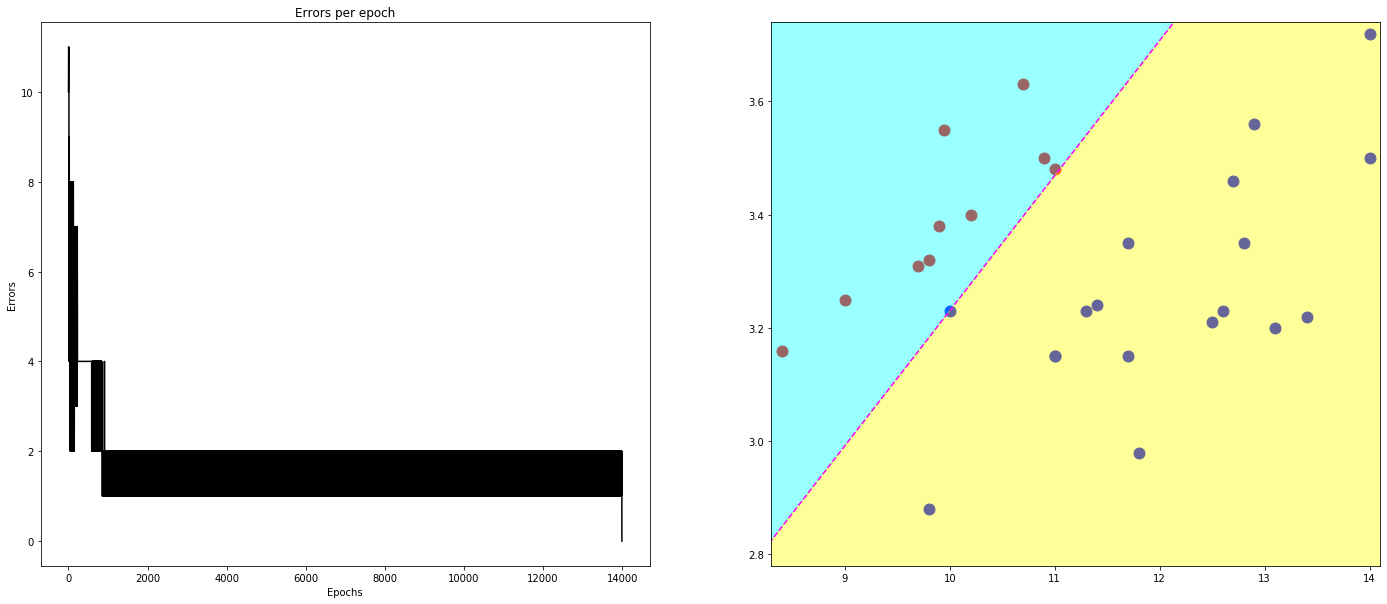

In [585]:
def draw_decision_boundary(ax, stat, wine_data, epoch):
    w1, w2 = stat[2][epoch]
    slope = -w1 / w2
    b = stat[3][epoch]
    b = -b / w2
    x = range(int(wine_data.loc[:, 'alcohol'].min()), int(wine_data.loc[:, 'alcohol'].max()) + 2)
    y = slope * x + b
    ax.plot(x, y, c='magenta', linestyle='--')
    
    y_max=  wine_data.loc[:, 'pH'].max() + 0.1
    y_min = wine_data.loc[:, 'pH'].min() - 0.1
    ax.fill_between(x, y, y_max, color='cyan', alpha=0.4)
    ax.fill_between(x, y, y_min, color='yellow', alpha=0.4)

def plot_performance(performance, wine_data, good_thres, bad_thres, epoch=-1, save_plot=False):
    """
    Function to plot perceptron's results
    ----------
    Parameters
    ----------
    performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    good_thres: int, good wine quality
    bad_thres: int, bad_wine_quality
    epoch: int, default < =, epoch to show decision boundary for. Should be < 0 to show the last epoch.
    save_plot: boolean, default: False, if True then saves the plot to the file: `plot_performance.png`
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
    stat = list(zip(*performance))
    if epoch < 0:
        epoch = len(stat[0]) - 1
    
    axes[0].set_title("Errors per epoch")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Errors")
    axes[0].plot(stat[0], stat[1], color='black')
    
    data = wine_data[(wine_data['quality'] >= good_thres) | (wine_data['quality'] <= bad_thres)]
    x_min = data.loc[:, 'alcohol'].min()
    x_max = data.loc[:, 'alcohol'].max()
    y_min = data.loc[:, 'pH'].min()
    y_max = data.loc[:, 'pH'].max()
    axes[1].set_xlim(x_min - 0.1, x_max + 0.1)
    axes[1].set_ylim(y_min - 0.0, y_max + 0.02)
    good_wines = wine_data[wine_data['quality'] >= good_thres]
    bad_wines = wine_data[wine_data['quality'] <= bad_thres]
    axes[1].scatter(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'], s=120, c='blue')
    axes[1].scatter(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'], s=120, c='red')
    draw_decision_boundary(axes[1], stat, wine_data, epoch)
    if save_plot:
        fig.savefig('plot_performance.png')
    return fig
fig = plot_performance(performance, red_wine, 8, 3, save_plot=True)